# Ensemble mean anomaly ACCESS-S2 forecasts for wet 2022 events

In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '03:00:00'
cores = 10
memory = str(4 * cores)
memory = memory + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52+gdata/ux62'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.6:45751,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [6]:
import os
import xarray as xr
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'

In [7]:
def get_plot_params():
    """
    Get the plotting parameters used for figures
    """
    FONT_SIZE = 7
    COASTLINES_LW = 0.5
    LINEWIDTH = 1.3
    PATHEFFECT_LW_ADD = LINEWIDTH * 1.8

    return {'lines.linewidth': LINEWIDTH,
            'hatch.linewidth': 0.5,
            'font.size': FONT_SIZE,
            'legend.fontsize' : FONT_SIZE - 1,
            'legend.columnspacing': 0.7,
            'legend.labelspacing' : 0.03,
            'legend.handlelength' : 1.,
            'axes.linewidth': 0.5}

plt_params = get_plot_params()

# Load hindcast climatology

In [8]:
hcast_clim = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/access-s2/pr_hindcast_month_clim_1981-2018.zarr',
    consolidated=True
)

In [9]:
hcast_clim = hcast_clim['pr']

# Load forecast data

In [10]:
fc_path = '/g/data/w42/lz3062/s2_fcst/'

Get initialisation dates

In [11]:
init_dates = sorted(os.listdir(fc_path)) # Initialisation dates. Note directory structure is different to hindcast data.

Obtain dataset of all forecasts, with dimensions for ensemble member (member; 1-33), lat, lon, forecast target date (target_date), forecast initialisation date (init_date).

### EDIT:
Actually, it is easier to compute the forecast anomalies if we have a lead time dimension (lead_time), so let's do that instead of a target date.

In [24]:
ds_list = []
for init in init_dates: # loop through each init date
    members = sorted(os.listdir(fc_path + init))
    files = []
    for member, file in enumerate(members):
        fcast = xr.open_mfdataset(fc_path + init + '/' + file)
        fcast = fcast.expand_dims({'member': [member + 1]}) # give this dataset the ensemble dimension
        files.append(fcast)
        
    fcast_ens = xr.concat(files, dim='member') # concatenate over all members
    # fcast_ens = fcast_ens.rename({'time': 'target_date'}) # rename time to target_date
    fcast_ens = fcast_ens.expand_dims({'init_date': [fcast_ens['time'].values[0]]}) # assign new init date dimension
    fcast_ens = fcast_ens.rename({'time': 'lead_time'}) # rename time to target_date
    fcast_ens = fcast_ens.assign_coords({'lead_time': range(len(fcast_ens['lead_time']))})
    
    ds_list.append(fcast_ens)
    
fcast_ds = xr.concat(ds_list, dim='init_date') # concat over all init dates

In [25]:
fcast_ds = fcast_ds['pr']

In [26]:
fcast_ds = fcast_ds.sel(
    lon=slice(110, 160),
    lat=slice(-45, -10)
)

In [27]:
fcast_ds

<xarray.DataArray 'pr' (init_date: 18, member: 33, lead_time: 42, lat: 63,
                        lon: 60)>
dask.array<getitem, shape=(18, 33, 42, 63, 60), dtype=float32, chunksize=(1, 1, 42, 63, 60), chunktype=numpy.ndarray>
Coordinates:
  * init_date  (init_date) datetime64[ns] 2022-02-22T12:00:00 ... 2022-10-01T...
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * lat        (lat) float32 -44.72 -44.17 -43.61 ... -11.39 -10.83 -10.28
  * lon        (lon) float32 110.4 111.2 112.1 112.9 ... 157.1 157.9 158.8 159.6
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
Attributes:
    stash_item:     216
    stash_model:    1
    lookup_source:  defaults (cdunifpp V0.14pre1)
    long_name:      TOTAL PRECIPITATION RATE     KG/M2/S
    cell_methods:   time: mean
    units:          kg m-2 s-1
    stash_section:  5
    standard_name:  precipitation_flux

# Calculate anomalies

In [29]:
anoms = fcast_ds.groupby('init_date.month') - hcast_clim

In [30]:
anoms

<xarray.DataArray 'pr' (init_date: 18, member: 33, lead_time: 42, lat: 63,
                        lon: 60)>
dask.array<sub, shape=(18, 33, 42, 63, 60), dtype=float32, chunksize=(1, 1, 42, 63, 60), chunktype=numpy.ndarray>
Coordinates:
  * init_date  (init_date) datetime64[ns] 2022-02-22T12:00:00 ... 2022-10-01T...
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * lat        (lat) float32 -44.72 -44.17 -43.61 ... -11.39 -10.83 -10.28
  * lon        (lon) float32 110.4 111.2 112.1 112.9 ... 157.1 157.9 158.8 159.6
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
    month      (init_date) int64 2 2 2 3 3 3 6 6 6 6 6 6 8 8 9 9 9 10

# Set forecast target periods

In [39]:
# format is {init_date: [first_target_date, last_target_date]}
feb_target_lead0 = {'2022-02-24': ['2022-02-24', '2022-03-02']}
mar_target_lead0 = {'2022-03-03': ['2022-03-03', '2022-03-09']}

jul_target_lead1 = {'2022-06-23': ['2022-06-30', '2022-07-06']}
jul_target_lead0 = {'2022-06-30': ['2022-06-30', '2022-07-06']}

oct_target_lead1 = {'2022-09-01': ['2022-10-01', '2022-10-31']}
oct_target_lead0 = {'2022-10-01': ['2022-10-01', '2022-10-31']}

Convert these to lead times.

In [40]:
for period in [
    feb_target_lead0,
    mar_target_lead0,
    jul_target_lead1,
    jul_target_lead0,
    oct_target_lead1,
    oct_target_lead0
]:
    # Get init and target dates (t1 and t2, corresponding to first and last day of target window)
    init = pd.to_datetime(list(period.keys())[0])
    t1 = pd.to_datetime(list(period.values())[0][0])
    t2 = pd.to_datetime(list(period.values())[0][1])
    
    # Calculate lead times and append to dict
    period[list(period.keys())[0]].append((t1 - init).days)
    period[list(period.keys())[0]].append((t2 - init).days)

# An example: Take a look at first period

In [72]:
init = list(feb_target_lead0.keys())[0]
lead_slice = slice(feb_target_lead0[init][2], feb_target_lead0[init][3] + 2) # Need two extra days lead time, for the 3 inits

In [73]:
i_init = np.where(pd.to_datetime(fcast_ds['init_date'].values) == init+'-12')[0][0]

In [74]:
fcast = fcast_ds.isel(init_date=range(i_init - 2, i_init + 1))
fcast = fcast.sel(lead_time=lead_slice)

In [75]:
fcast

<xarray.DataArray 'pr' (init_date: 3, member: 33, lead_time: 9, lat: 324,
                        lon: 432)>
dask.array<getitem, shape=(3, 33, 9, 324, 432), dtype=float32, chunksize=(1, 1, 9, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * init_date  (init_date) datetime64[ns] 2022-02-22T12:00:00 ... 2022-02-24T...
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * lat        (lat) float32 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon        (lon) float32 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.8 359.6
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8
Attributes:
    stash_item:     216
    stash_model:    1
    lookup_source:  defaults (cdunifpp V0.14pre1)
    long_name:      TOTAL PRECIPITATION RATE     KG/M2/S
    cell_methods:   time: mean
    units:          kg m-2 s-1
    stash_section:  5
    standard_name:  precipitation_flux

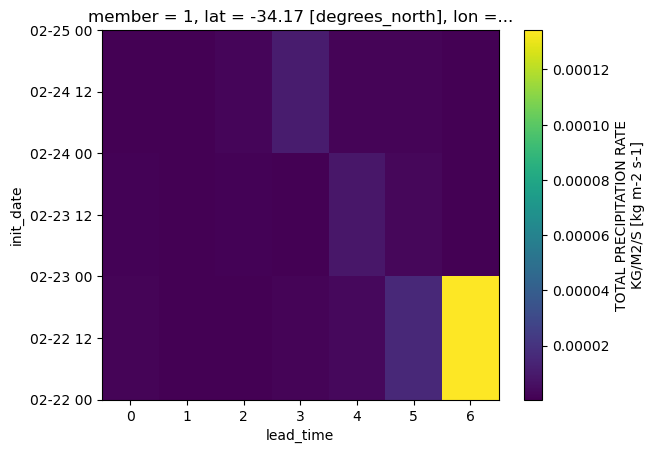

In [58]:
fcast.isel(lat=100, lon=100, member=0).plot()

In [45]:
months = fcast['init_date'].dt.month.values
months

array([2, 2, 2])

### Compute climatology for this period

This should be the climatology for each month of the forecast init, and for each member separately. We need the ensemble to calculate how much of our forecast ensemble is in each tercile of the climatological distribution.

This provides the climatology for each forecast day. We now need to obtain the climatology for the width of the forecast window, i.e. one week, one month etc. So take the mean over the window for the appropriate lead times.

In [67]:
feb_target_lead0

{'2022-02-24': ['2022-02-24', '2022-03-02', 0, 6]}

In [102]:
fda_list = []
for i, init in enumerate(fcast['init_date']): # For each init date
    # Forecasts =============
    
    # Size of forecast window (we know to subtract 2 because  there are 3 inits per period)
    window_length = len(fcast['lead_time']) - 2
    # Take correct leads (lead 2-8 for first init, 1-7 for second, 0-6 for third)
    window = range(2 - i, window_length + 2 - i)
    # Select and take mean over lead_time
    fda = fcast.sel(init_date=init).isel(lead_time=window).mean('lead_time')
    
    fda_list.append(fda)
    
    # Climatology ===============
    
    
    
# hcast_clim.sel(month=2)

In [103]:
xr.concat(fda_list, dim='init_date').mean('init_date')

<xarray.DataArray 'pr' (member: 33, lat: 324, lon: 432)>
dask.array<mean_agg-aggregate, shape=(33, 324, 432), dtype=float32, chunksize=(1, 324, 432), chunktype=numpy.ndarray>
Coordinates:
  * member   (member) int64 1 2 3 4 5 6 7 8 9 10 ... 25 26 27 28 29 30 31 32 33
  * lat      (lat) float32 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon      (lon) float32 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.8 359.6

In [49]:
anoms = fcast.groupby('init_date.month') - hcast_clim

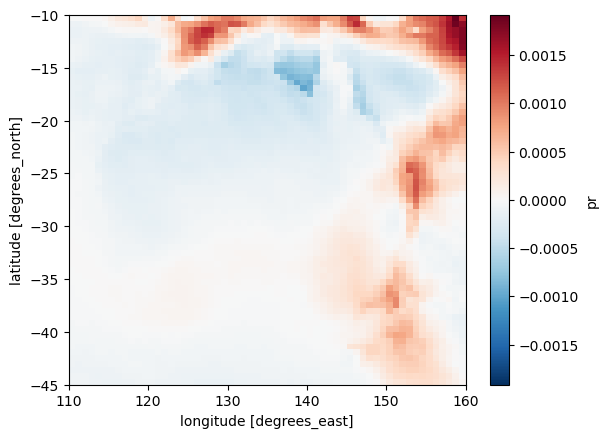

In [54]:
anoms.sum('lead_time').mean('member').mean('init_date').plot()

In [145]:
aus_region = [110, 155, -10, -45]

In [148]:
fcast_plot = fcast.sel(
    lon=slice(aus_region[0], aus_region[1]),
    lat=slice(aus_region[3], aus_region[2])
)

Mean rainfall forecast for 24/02 through 02/03, initialised on 24/02.
Ensemble average of 99 members from 3 initialisation dates.

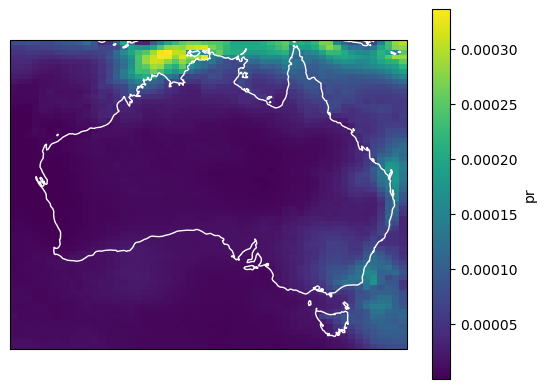

In [152]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fcast_plot.mean(['init_date', 'target_date', 'member']).plot(ax=ax)
ax.coastlines(color='white')